In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [16]:
train_dir = 'fall_detection_data/train'
val_dir = 'fall_detection_data/val'
test_dir = 'fall_detection_data/test'

In [17]:
# Set the image size
IMG_SIZE = 224  # Adjusted image size for VGG16

# Load VGG16 model with ImageNet weights, excluding the top layers (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add GlobalAveragePooling2D after the last Conv2D layer to reduce dimensionality
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)

In [18]:
# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define data generators
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    vertical_flip=True,
    validation_split=0.2,  # Split for training and validation
    zoom_range=0.2, 
    horizontal_flip=True
)
# Use the same ImageDataGenerator for validation with validation_split
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation_split here

train_generator = datagen.flow_from_directory(
    train_dir, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=16,
    class_mode='categorical',
    subset='training'  # Set this for training data
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=16,
    class_mode='categorical',
    subset='validation'  # Set this for validation data
)
# Define callbacks (EarlyStopping, Checkpoint)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("vgg16_model.keras", save_best_only=True, monitor='val_loss')
]


Found 1841 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


In [19]:
# Train the model
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Reduced for testing purposes, adjust as needed
    steps_per_epoch=train_generator.samples // 16,
    validation_steps=val_generator.samples // 16,
    callbacks=callbacks
)


Epoch 1/10


c:\Users\merug\anaconda3\envs\cuda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/115 ━━━━━━━━━━━━━━━━━━━━ 7:56 4s/step - accuracy: 0.3924 - loss: 21.2236

KeyboardInterrupt: 

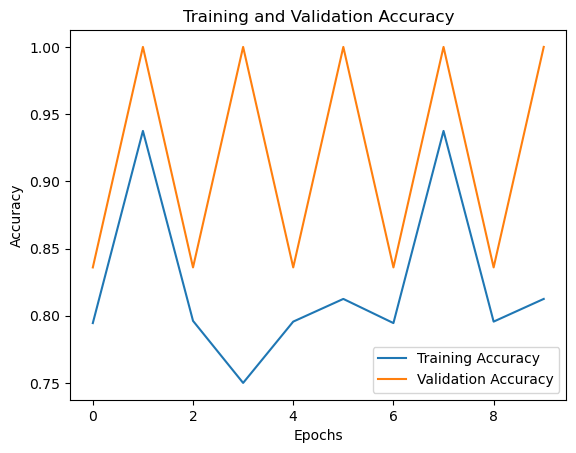

In [21]:
# ---------------- Plot Training and Validation Accuracy ---------------- #
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<!-- 

### In Summary:
This correlation matrix is a visual tool to understand how the features extracted by the VGG16 model are related to each other. It helps to assess the diversity and redundancy in the feature space. The high density of red/orange areas suggests that many features are positively correlated, while some areas of blue indicate negatively correlated features. Ideally, for a well-functioning model, you want a balance of correlations, with not too many redundant features. -->

<!-- - Feature Redundancy: There seems to be quite a bit of feature redundancy (strong positive correlation) in the extracted feature space, which might mean that the model is capturing similar patterns multiple times. This could be improved by reducing redundant features or regularizing the model.
- Diverse and Complementary Features: The presence of blue (negative correlation) and weaker positive correlations indicates that the model is also learning diverse and complementary features, which is beneficial for the model’s ability to generalize to new data.
- Further Fine-Tuning: The amount of strong correlation suggests that further fine-tuning or regularization techniques might help reduce the redundancy and improve the overall performance and generalization of the model. -->

Vgg19

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [25]:
# Load VGG19 model with ImageNet weights, excluding the top layers (fully connected layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add GlobalAveragePooling2D after the last Conv2D layer to reduce dimensionality
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:

# Define your data generators
train_generator = datagen.flow_from_directory(
    train_dir, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)


Found 1841 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


In [27]:
# Get the output of the last Conv2D layer of VGG19
conv_layer_output = base_model.get_layer('block5_conv4').output
pooled_output = tf.keras.layers.GlobalAveragePooling2D()(conv_layer_output)

# Create the feature extraction model using the pooled output
feature_extractor = Model(inputs=base_model.input, outputs=pooled_output)

# Function to extract features from the validation dataset
def extract_features(feature_extractor, data_generator, num_batches=10):  # Increase batches for more variability
    features = []
    for i, (batch_images, _) in enumerate(data_generator):
        if i >= num_batches:  # Process only a certain number of batches to save time
            break
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
    return np.vstack(features)

# Extract features from the validation set
features = extract_features(feature_extractor, val_generator, num_batches=10)

# Compute standard deviations for each feature
stddev = np.std(features, axis=0)

# Only keep features with non-zero standard deviation to avoid NaN values
non_constant_features = features[:, stddev > 0]

# Now calculate the correlation matrix on the filtered features
correlation_matrix = np.corrcoef(non_constant_features.T)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Epoch 1/30


c:\Users\merug\anaconda3\envs\cuda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7629 - loss: 15.6887
Epoch 1: val_loss improved from inf to 0.87264, saving model to vgg19_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 629s 5s/step - accuracy: 0.7631 - loss: 15.5885 - val_accuracy: 0.8359 - val_loss: 0.8726
Epoch 2/30
  1/115 ━━━━━━━━━━━━━━━━━━━━ 9:38 5s/step - accuracy: 0.8125 - loss: 1.0254

c:\Users\merug\anaconda3\envs\cuda\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.87264 to 0.25941, saving model to vgg19_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8125 - loss: 1.0254 - val_accuracy: 1.0000 - val_loss: 0.2594
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8048 - loss: 0.5188
Epoch 3: val_loss did not improve from 0.25941
115/115 ━━━━━━━━━━━━━━━━━━━━ 587s 5s/step - accuracy: 0.8047 - loss: 0.5189 - val_accuracy: 0.8398 - val_loss: 0.4586
Epoch 4/30
  1/115 ━━━━━━━━━━━━━━━━━━━━ 9:20 5s/step - accuracy: 0.9375 - loss: 0.3455
Epoch 4: val_loss did not improve from 0.25941
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9375 - loss: 0.3455 - val_accuracy: 0.6667 - val_loss: 0.6585
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7740 - loss: 0.5396
Epoch 5: val_loss did not improve from 0.25941
115/115 ━━━━━━━━━━━━━━━━━━━━ 582s 5s/step - accuracy: 0.7741 - loss: 0.5394 - val_accuracy: 0.8359 - val_loss: 0.4588
Epoch 6/30
  1/115 ━━━━━━━━━━━━━━━━━━━━ 9:01

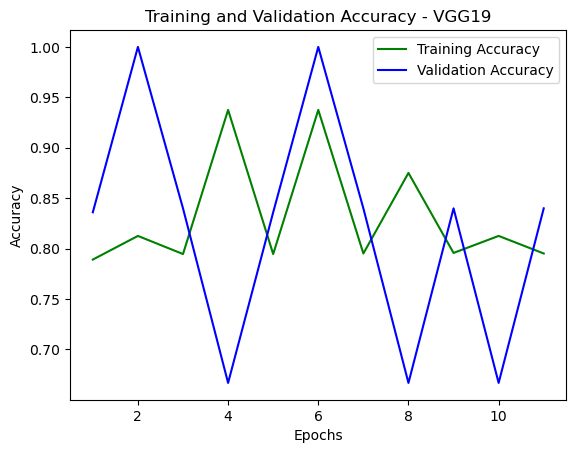

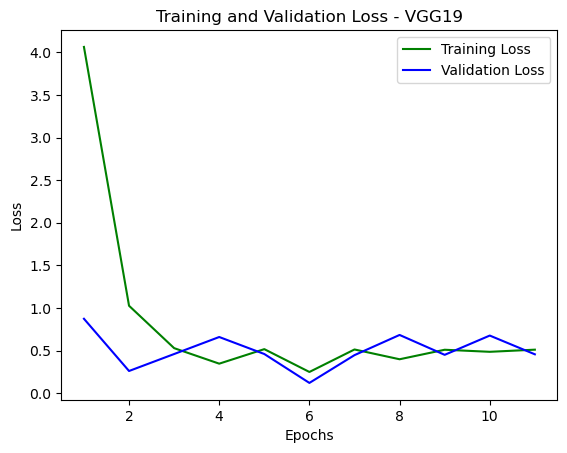

In [29]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("vgg19_model.keras", save_best_only=True, monitor='val_loss', verbose=1)
]

# Train the VGG19 model
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # You can adjust the number of epochs as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=callbacks
)

# Plot training and validation accuracy
import matplotlib.pyplot as plt

# Extract training and validation accuracy
acc_train = model_history.history['accuracy']
acc_val = model_history.history['val_accuracy']

# Define epochs
epochs = range(1, len(acc_train) + 1)



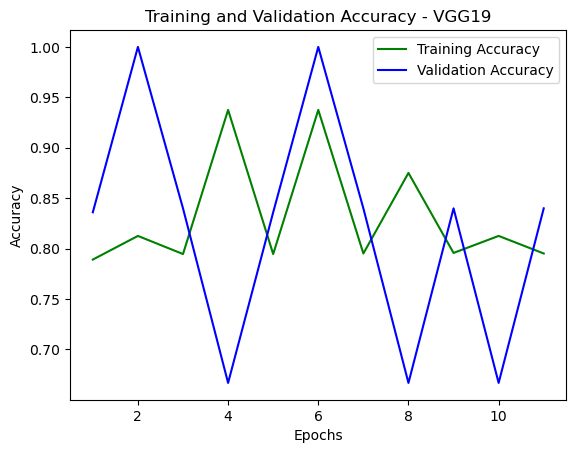

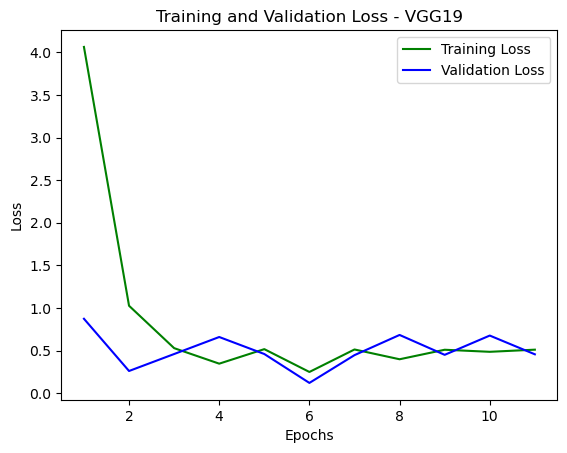

In [30]:

# Plot training and validation accuracy
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - VGG19')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss_train = model_history.history['loss']
loss_val = model_history.history['val_loss']

# Plot training and validation loss
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss - VGG19')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Resnet

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [11]:
# Set the image size
IMG_SIZE = 224

# Load ResNet50 model with ImageNet weights, excluding the top layers (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add GlobalAveragePooling2D after the last Conv2D layer to reduce dimensionality
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)


In [12]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
# Callbacks (EarlyStopping and Checkpoint)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("resnet_model.keras", save_best_only=True, monitor='val_loss')
]


In [14]:
# Train the model
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // 16,
    validation_steps=val_generator.samples // 16,
    callbacks=callbacks
)

Epoch 1/30


c:\Users\merug\anaconda3\envs\cuda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7865 - loss: 0.5932 - val_accuracy: 0.8359 - val_loss: 0.4703
Epoch 2/30
  1/115 ━━━━━━━━━━━━━━━━━━━━ 3:35 2s/step - accuracy: 0.7500 - loss: 0.4032

c:\Users\merug\anaconda3\envs\cuda\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7500 - loss: 0.4032 - val_accuracy: 1.0000 - val_loss: 0.1088
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8484 - loss: 0.3707 - val_accuracy: 0.8359 - val_loss: 5.2565
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8125 - loss: 0.4147 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8285 - loss: 0.4929 - val_accuracy: 0.8359 - val_loss: 3.6637
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.1588 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.8251 - loss: 0.3987 - val_accuracy: 0.8398 - val_loss: 3.3935
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8750 - loss: 0.5066 - val_accuracy: 0.6667 - val_loss: 7.2573
Epoch 9/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.8482 - loss: 0.3419 - val_accuracy:

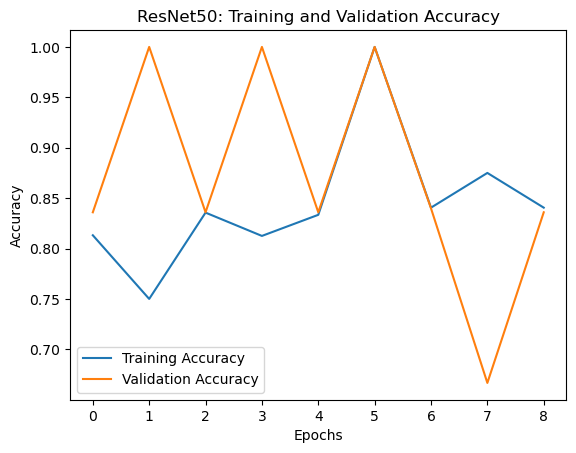

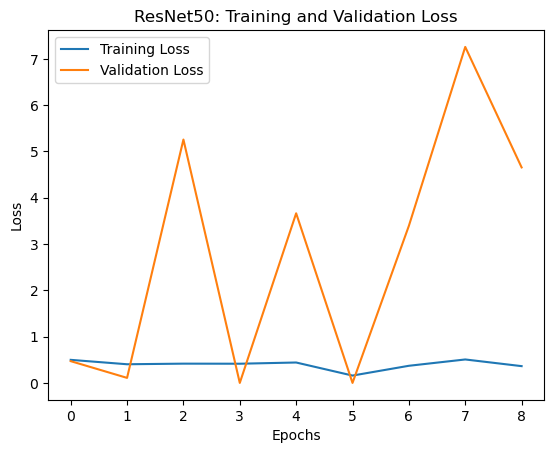

In [15]:
# Plot training and validation accuracy
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [20]:
# Define image size
IMG_SIZE = 224

# Load pre-trained ResNet50 without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze most of the layers in the base model, but leave the last few layers trainable
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Add a dense layer for better feature learning
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(2, activation='softmax')(x)  # Assuming binary classification (fall/no-fall)

# Create the full model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a small learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler to reduce learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint('resnet50_finetuned.keras', monitor='val_loss', save_best_only=True)

# Combine callbacks
callbacks = [early_stopping, checkpoint, lr_scheduler]


In [21]:
# Train the model
model_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // 16,
    validation_steps=val_generator.samples // 16,
    callbacks=callbacks
)


Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 89s 702ms/step - accuracy: 0.7559 - loss: 0.5582 - val_accuracy: 0.8516 - val_loss: 0.4919 - learning_rate: 1.0000e-04
Epoch 2/30
  1/115 ━━━━━━━━━━━━━━━━━━━━ 1:00 530ms/step - accuracy: 0.8750 - loss: 0.3097

c:\Users\merug\anaconda3\envs\cuda\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3097 - val_accuracy: 1.0000 - val_loss: 0.5682 - learning_rate: 1.0000e-04
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 695ms/step - accuracy: 0.7956 - loss: 0.4536 - val_accuracy: 0.5078 - val_loss: 0.7088 - learning_rate: 1.0000e-04
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.4138 - val_accuracy: 1.0000 - val_loss: 0.5607 - learning_rate: 1.0000e-04
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 82s 699ms/step - accuracy: 0.7857 - loss: 0.4444 - val_accuracy: 0.8633 - val_loss: 0.3662 - learning_rate: 5.0000e-05
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8125 - loss: 0.3642 - val_accuracy: 1.0000 - val_loss: 0.3384 - learning_rate: 5.0000e-05
Epoch 7/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 84s 715ms/step - accuracy: 0.8130 - loss: 0.4053 - val_accuracy: 0.8906 - val_loss: 0.3710 - learning_rate: 5.0000e-05
Epoch 8/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0

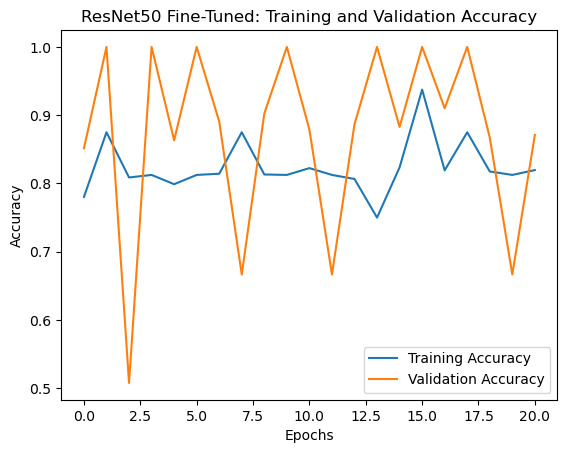

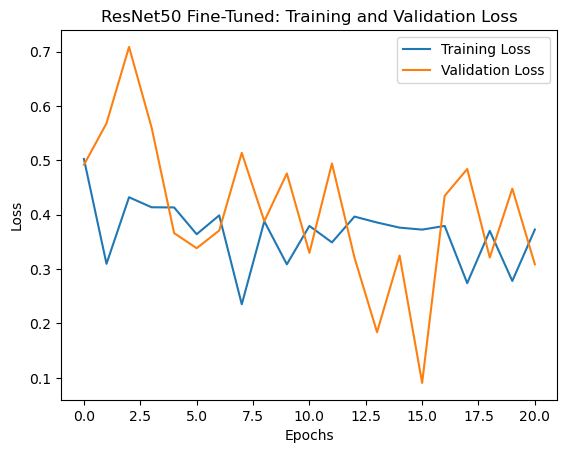

In [24]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Fine-Tuned: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Fine-Tuned: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

confusion matrix

Diagonal Dominance: The main diagonal of the matrix is red, indicating a perfect correlation (value = 1) of each feature with itself. This is expected behavior for any correlation matrix.

Minimal Off-Diagonal Correlation: The values off the main diagonal appear to be very close to zero (indicated by the deep blue color). This suggests that the PCA-reduced features are largely uncorrelated with one another, which is a good sign that the dimensionality reduction via PCA has effectively decorrelated the features.

This implies that the PCA has worked well in terms of extracting independent components from the feature space.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Set the image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 16

# Define your data directories
train_dir = 'fall_detection_data/train'
val_dir = 'fall_detection_data/val'

In [3]:
# Define ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:

val_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2300 images belonging to 2 classes.
Found 1297 images belonging to 2 classes.


In [5]:
# Define a function to extract features and compute correlation matrix
def extract_features_and_plot_correlation(model, layer_name, data_generator, num_batches=10):
    # Get the output of the specified convolutional layer
    conv_layer_output = model.get_layer(layer_name).output
    feature_extractor = Model(inputs=model.input, outputs=conv_layer_output)

    # Function to extract features from the dataset
    def extract_features(feature_extractor, data_generator, num_batches=10):
        features = []
        for i, (batch_images, _) in enumerate(data_generator):
            if i >= num_batches:
                break
            batch_features = feature_extractor.predict(batch_images)
            features.append(batch_features)
        return np.vstack(features)

    # Extract features
    features = extract_features(feature_extractor, data_generator, num_batches)

    # Flatten the feature maps
    flattened_features = features.reshape(features.shape[0], -1)

    # Perform PCA to reduce the dimensionality
    pca = PCA(n_components=min(100, flattened_features.shape[0]))  # Use 100 components or the max number of samples
    reduced_features = pca.fit_transform(flattened_features)

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(reduced_features.T)

    # Plot the correlation matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm')
    plt.title(f'Feature Correlation Matrix (PCA Reduced Features) - {model.name}')
    plt.show()

In [6]:

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [7]:
# Function to compute predictions and plot confusion matrix for the given model
def compute_predictions_and_plot_confusion_matrix(model, data_generator, class_indices, model_name):
    # Get true labels and predicted labels
    y_true = []
    y_pred = []
    for batch_images, batch_labels in data_generator:
        batch_pred = model.predict(batch_images)
        y_true.extend(np.argmax(batch_labels, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))
    
    # Plot the confusion matrix
    plot_confusion_matrix(y_true, y_pred, list(class_indices.keys()), model_name)

In [8]:

# Example for VGG16, VGG19, and ResNet50:
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [11]:

# Use the corresponding last convolutional layer names for each model
layer_names = {
    'VGG16': 'block5_conv3',
    'VGG19': 'block5_conv4',
    'ResNet50': 'conv5_block3_out'
}

In [12]:

# Example: Train VGG16 model (you can do the same for VGG19 and ResNet50)
# Add top layers for classification
x = base_vgg16.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
vgg16_model = Model(inputs=base_vgg16.input, outputs=x)

# Compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("vgg16_model.keras", save_best_only=True, monitor='val_loss')
]

# Train the model
model_history = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)




Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - accuracy: 0.7354 - loss: 5.2440 - val_accuracy: 0.8364 - val_loss: 0.4662
Epoch 2/10
  1/143 ━━━━━━━━━━━━━━━━━━━━ 11:03 5s/step - accuracy: 0.8750 - loss: 0.4233

c:\Users\merug\anaconda3\envs\cuda\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8750 - loss: 0.4233 - val_accuracy: 1.0000 - val_loss: 0.2538
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 821s 6s/step - accuracy: 0.7908 - loss: 0.5146 - val_accuracy: 0.8364 - val_loss: 0.4573
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6875 - loss: 0.6410 - val_accuracy: 1.0000 - val_loss: 0.2685
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 790s 6s/step - accuracy: 0.7997 - loss: 0.5076 - val_accuracy: 0.8364 - val_loss: 0.4463
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8125 - loss: 0.4826 - val_accuracy: 1.0000 - val_loss: 0.1968
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 690s 5s/step - accuracy: 0.7899 - loss: 0.5186 - val_accuracy: 0.8364 - val_loss: 0.4463
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6875 - loss: 0.6742 - val_accuracy: 1.0000 - val_loss: 0.2006
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step - accuracy: 0.8056 - loss: 0.4935 - val_accuracy: 0.8364 

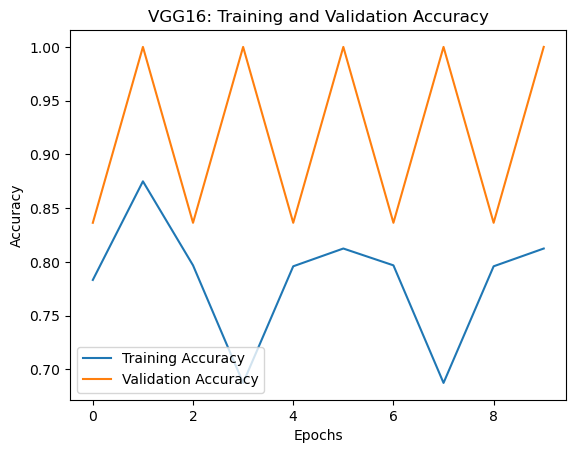

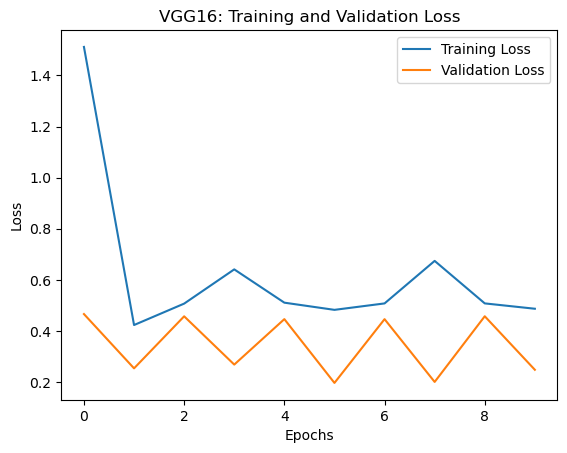

In [13]:
# Plot training and validation accuracy
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16: Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()